# Определение стоимости автомобилей

**Цель:** построить модель для определения стоимости автомобиля

-----
## Подготовка данных

-----

In [1]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


RANDOM_STATE = 12345

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('.\\data\\autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
# Скопируем датасет, чтобы потом узнать сколько процентов мы удалили
data_original = data.copy()

In [4]:
# приведем названия колонок к нижнему регистру 
data.columns = data.columns.str.lower()

data = data.rename(columns={'datecrawled': 'date_crawled',
                            'vehicletype': 'vehicle_type',
                           'registrationyear': 'registration_year',
                           'registrationmonth': 'registration_month',
                           'fueltype': 'fuel_type',
                           'datecreated': 'date_created',
                           'numberofpictures': 'number_of_pictures',
                           'postalcode' : 'postal_code',
                           'lastseen': 'last_seen'})

In [5]:
def get_data_info(data):
    data.info()
    display(data.describe())
    print('Количество пропусков в %')
    display(pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('BuPu'))
    print('Проверка на явные дубликаты')
    display(data[data.duplicated()])
    print('Кол-во дубликатов:', data.duplicated().sum())
    print('Кол-во уникальных марок автомобилей:', len(data['brand'].unique()))
    print('Кол-во уникальных моделей автомобилей:', len(data['model'].unique()))
    print('------------------------------------------------------------------------------------------------------------')
    
    plt.figure(figsize = (15,15))
    plt.subplot(3, 3, 1)
    data['price'].plot(kind = 'box')
    plt.subplot(3, 3, 4)
    # Фильтрация только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])    
    display(sns.heatmap((numeric_data).corr(method='spearman'), annot = True, vmin=-1, vmax=1, center= 0)) # значения корреляции через хитмэп

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество пропусков в %


,0
date_crawled,0.000000
price,0.000000
vehicle_type,11.000000
registration_year,0.000000
gearbox,6.000000
power,0.000000
model,6.000000
kilometer,0.000000
registration_month,0.000000
fuel_type,9.000000


Проверка на явные дубликаты


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Кол-во дубликатов: 4
Кол-во уникальных марок автомобилей: 40
Кол-во уникальных моделей автомобилей: 251
------------------------------------------------------------------------------------------------------------


<Axes: >

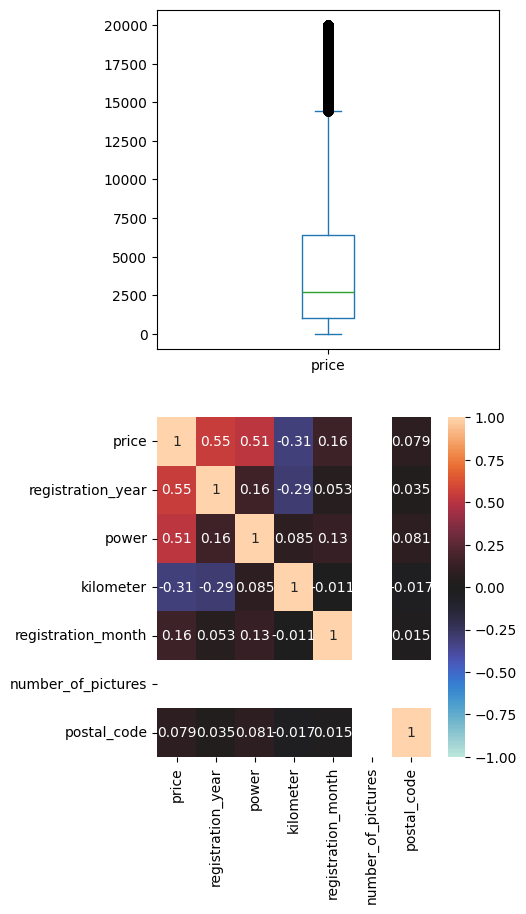

In [6]:
get_data_info(data)

 **Признаки**
 
* DateCrawled — дата скачивания анкеты из базы

* VehicleType — тип автомобильного кузова

* RegistrationYear — год регистрации автомобиля

* Gearbox — тип коробки передач

* Power — мощность (л. с.)

* Model — модель автомобиля

* Kilometer — пробег (км)

* RegistrationMonth — месяц регистрации автомобиля

* FuelType — тип топлива

* Brand — марка автомобиля

* Repaired — была машина в ремонте или нет

* DateCreated — дата создания анкеты

* NumberOfPictures — количество фотографий автомобиля

* PostalCode — почтовый индекс владельца анкеты (пользователя)

* LastSeen — дата последней активности пользователя

**Целевой признак**

* Price — цена (евро)

> **Присутствуют**
> * дубликаты
> * NaN`ы в категоральных признаках
> * аномальные значения в численных признаках 
> * есть маленькая обратная зависимость между ценой и проейденным километром 

In [7]:
# Удаляем дубликаты
data = data.drop_duplicates(keep = False).reset_index(drop=True)

In [8]:
# Заменить пропуски в категоральных признках можно:
# 1) заменить пропущенное значение новой категорией "Неизвестно".
# 2) заменить пропущенное значение наиболее популярным значением.
def category(df):
    cat_columns = ['fuel_type','model','vehicle_type', 'gearbox', 'repaired']
    for i in cat_columns:
        print('___________________')
        print(f'columns: {i}')
        print('___________________')
        print(df[i].value_counts())
        print('количество пропусков:', df[i].isnull().sum())
        print('------------------------------------------------')

In [9]:
category(data)

___________________
columns: fuel_type
___________________
fuel_type
petrol      216346
gasoline     98718
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64
количество пропусков: 32895
------------------------------------------------
___________________
columns: model
___________________
model
golf                  29232
other                 24419
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64
количество пропусков: 19705
------------------------------------------------
___________________
columns: vehicle_type
___________________
vehicle_type
sedan          91457
small          79829
wagon          65164
bus            28775
convertible    20203
coupe          16159
suv      

In [10]:
# Слишком много пропущенных значений, чтобы заменять их на более популярное название, поэтому присудим им категорию "other"
cat_columns = ['fuel_type','model','vehicle_type', 'gearbox']
for i in cat_columns:
    data[i].fillna('other', inplace = True)

In [11]:
# будем считать, что машина не была в ремонте, если присутсвует пропуск в колонке repaired
data['repaired'].fillna('no', inplace=True)

In [12]:
# Посмотрим на категоральные признаки после преобразований
def category_after_transformation(df):
    cat_columns = ['fuel_type','model','vehicle_type', 'gearbox', 'repaired']
    for i in cat_columns:
        print('___________________')
        print(f'columns: {i}')
        print('___________________')
        print(df[i].value_counts())
        print('количество пропусков:', df[i].isnull().sum())
        print('------------------------------------------------')

In [13]:
category_after_transformation(data)

___________________
columns: fuel_type
___________________
fuel_type
petrol      216346
gasoline     98718
other        33099
lpg           5310
cng            565
hybrid         233
electric        90
Name: count, dtype: int64
количество пропусков: 0
------------------------------------------------
___________________
columns: model
___________________
model
other                 44124
golf                  29232
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 250, dtype: int64
количество пропусков: 0
------------------------------------------------
___________________
columns: vehicle_type
___________________
vehicle_type
sedan          91457
small          79829
wagon          65164
other          40778
bus            28775
convertible    20203
coupe          16

In [14]:
def numerical(df):
    numerical_columns = ['registration_year', 'price', 'power']
    for i in numerical_columns:
        print('___________________________')
        print(f'columns: {i}')
        print('___________________________')
        print(df[i].describe())
        display(df[i].unique())
        display(df[i].value_counts())
        
        plt.figure(figsize = (20,20))
        plt.subplot(3, 3, 1)
        df[i].plot(kind = 'hist', bins = 100, title = f'{i}');
        print('----------------------------------------------------')

___________________________
columns: registration_year
___________________________
count    354361.000000
mean       2004.234515
std          90.228975
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64


array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

registration_year
2000    24490
1999    22726
2005    22109
2001    20122
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: count, Length: 151, dtype: int64

----------------------------------------------------
___________________________
columns: price
___________________________
count    354361.000000
mean       4416.702885
std        4514.194184
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64


array([  480, 18300,  9800, ..., 12395, 18429, 10985], dtype=int64)

price
0        10772
500       5670
1500      5394
1000      4647
1200      4594
         ...  
1368         1
233          1
11080        1
16340        1
10985        1
Name: count, Length: 3731, dtype: int64

----------------------------------------------------
___________________________
columns: power
___________________________
count    354361.000000
mean        110.093295
std         189.852256
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64


array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

power
0       40225
75      24023
60      15897
150     14590
101     13298
        ...  
610         1
6006        1
5815        1
6018        1
1241        1
Name: count, Length: 712, dtype: int64

----------------------------------------------------


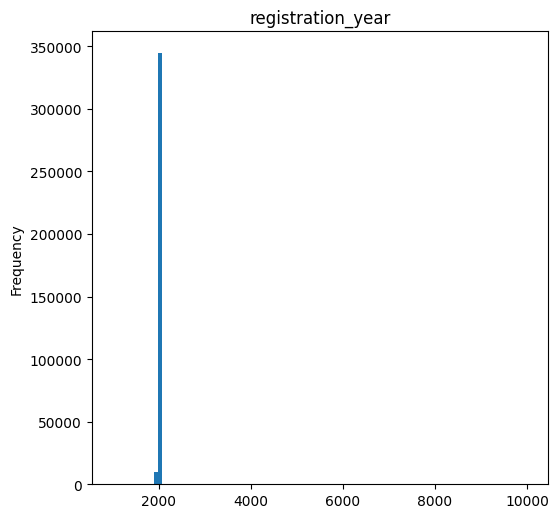

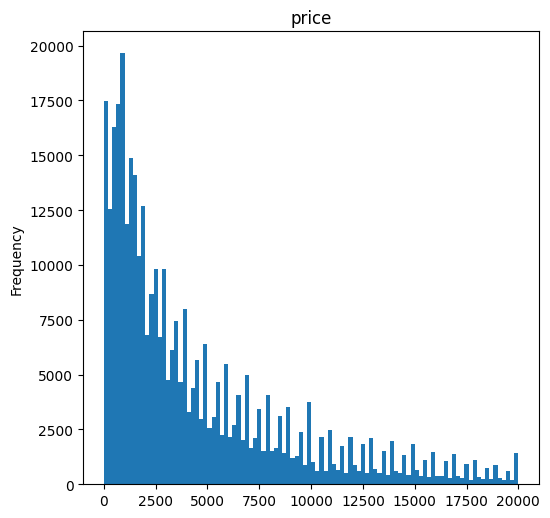

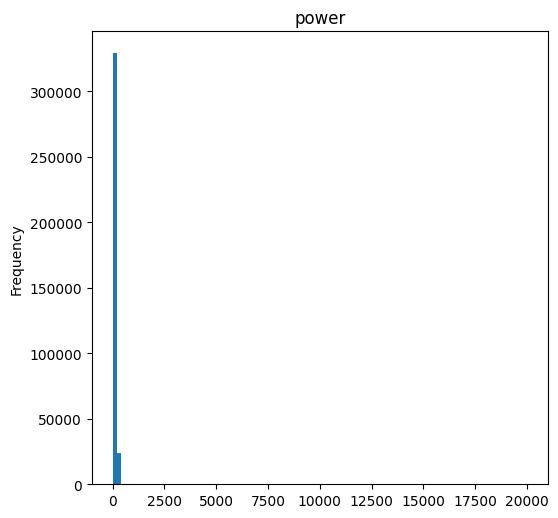

In [15]:
numerical(data)

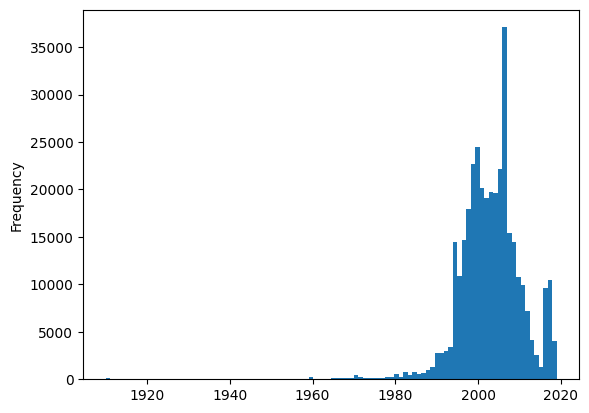

In [16]:
# Посмотрим срез по годам до 2023 года
data.query('1900 < registration_year < 2023')['registration_year'].plot(kind = 'hist', bins =100);

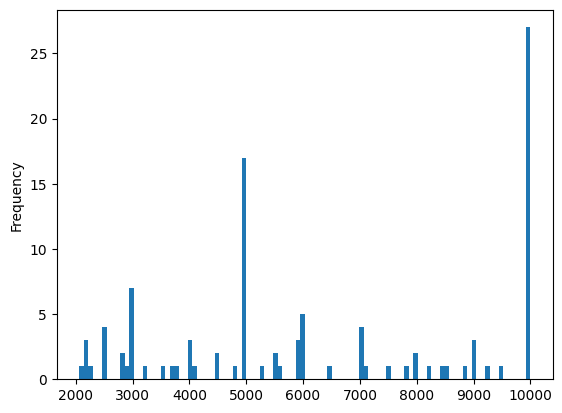

In [17]:
# Посмотрим на срез выше 2023 года
data.query('2023 < registration_year')['registration_year'].plot(kind = 'hist', bins =100);

In [18]:
data['date_created'] = pd.to_datetime(data['date_created'])

In [19]:
data['year_created'] = data['date_created'].dt.year
data['month_created'] = data['date_created'].dt.month
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,year_created,month_created
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24,0,70435,2016-04-07 03:16:57,2016,3
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50,2016,3
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14,0,90480,2016-04-05 12:47:46,2016,3
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17,2016,3
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21,2016,3


In [20]:
# Год регистрации автомобиля не может быть больше даты создания объявления
data.query('year_created < registration_year')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,year_created,month_created
22,2016-03-23 14:52:51,2900,other,2018,manual,90,meriva,150000,5,petrol,opel,no,2016-03-23,0,49716,2016-03-31 01:16:33,2016,3
26,2016-03-10 19:38:18,5555,other,2017,manual,125,c4,125000,4,other,citroen,no,2016-03-10,0,31139,2016-03-16 09:16:46,2016,3
48,2016-03-25 14:40:12,7750,other,2017,manual,80,golf,100000,1,petrol,volkswagen,no,2016-03-25,0,48499,2016-03-31 21:47:44,2016,3
51,2016-03-07 18:57:08,2000,other,2017,manual,90,punto,150000,11,gasoline,fiat,yes,2016-03-07,0,66115,2016-03-07 18:57:08,2016,3
57,2016-03-10 20:53:19,2399,other,2018,manual,64,other,125000,3,other,seat,no,2016-03-10,0,33397,2016-03-25 10:17:37,2016,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354104,2016-03-11 15:49:51,3600,other,2017,manual,86,transit,150000,5,gasoline,ford,no,2016-03-11,0,32339,2016-03-12 05:45:02,2016,3
354132,2016-03-29 16:47:29,1000,other,2017,manual,101,a4,150000,9,other,audi,no,2016-03-29,0,38315,2016-04-06 02:44:27,2016,3
354195,2016-03-17 00:56:26,2140,other,2018,manual,80,fiesta,150000,6,other,ford,no,2016-03-17,0,44866,2016-03-29 15:45:04,2016,3
354245,2016-03-25 09:37:59,1250,other,2018,other,0,corsa,150000,0,petrol,opel,no,2016-03-25,0,45527,2016-04-06 07:46:13,2016,3


In [21]:
# Предположим, что в одном и том же году машина была куплена и выставлена на продажу, тогда нужно, чтобы и месяц регистрации
# был раньше, чем месяц выставленного объявления
data.query('year_created == registration_year').query('month_created < registration_month')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen,year_created,month_created
31,2016-03-29 16:57:02,899,other,2016,manual,60,clio,150000,6,petrol,renault,no,2016-03-29,0,37075,2016-03-29 17:43:07,2016,3
35,2016-03-08 07:54:46,350,other,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08,0,19386,2016-03-08 09:44:50,2016,3
200,2016-04-03 20:44:13,1999,other,2016,manual,110,almera,150000,9,gasoline,nissan,no,2016-04-03,0,10997,2016-04-05 21:17:18,2016,4
294,2016-03-10 20:43:12,2390,other,2016,other,83,jazz,150000,12,petrol,honda,no,2016-03-10,0,78713,2016-03-13 03:17:27,2016,3
409,2016-03-08 23:53:58,4500,other,2016,other,0,fox,60000,10,other,volkswagen,no,2016-03-08,0,41466,2016-04-06 23:17:29,2016,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354099,2016-03-09 12:51:50,395,other,2016,manual,60,golf,150000,12,petrol,volkswagen,no,2016-03-09,0,25575,2016-04-05 23:45:21,2016,3
354107,2016-03-07 11:59:24,299,other,2016,manual,60,astra,150000,4,petrol,opel,yes,2016-03-07,0,49326,2016-03-20 01:46:49,2016,3
354161,2016-03-29 19:50:03,3000,other,2016,manual,0,colt,150000,8,gasoline,mitsubishi,no,2016-03-29,0,45472,2016-04-06 05:46:43,2016,3
354190,2016-03-10 23:36:19,1350,other,2016,manual,0,clk,150000,8,other,mercedes_benz,yes,2016-03-10,0,26427,2016-03-13 02:45:51,2016,3


In [22]:
data['year_created'].unique()

array([2016, 2015, 2014])

> **Так как в датасате нет объявлений выше 2016 года, то именно он будет верхним пределом для года регистрации автомобилей**

In [23]:
# По распределению видно, что данные о машинах, год регистрации которых нижен 1960, не корретны и их слишком мало
# их можно удалить (и на авито меньше 1960 года не найти) 
data = data.query('1960 < registration_year < 2016').reset_index(drop=True)

In [24]:
data['registration_month'].unique()

array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

In [25]:
# Необходимо удалить признаки с 0 месяцем  регистрации, так как это явная ошибка
data = data[data['registration_month'] > 0]

In [26]:
# Почти 14 тыс. машин имеют цену от 0 до 99 евро
# Из них ~11 тыс. имеют цену 0
data.query('price > 0')['price'].describe()

count    293554.000000
mean       4896.557856
std        4615.111555
min           1.000000
25%        1399.000000
50%        3200.000000
75%        6999.000000
max       20000.000000
Name: price, dtype: float64

In [27]:
data['price'].quantile([.07])

0.07    500.0
Name: price, dtype: float64

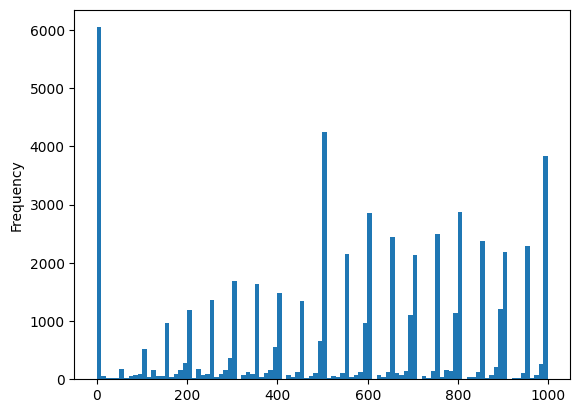

In [28]:
data.query('price < 1000')['price'].plot(kind = 'hist', bins = 100);

> Анализируя цены на машины на [авито](https://www.avito.ru/all/avtomobili?cd=1&p=18&s=1), можно понять, что те, кто ставит низкую цену, хотят договориться об оплате лично или машина идет в разбор (битая). Что-то более менее адекватное только от 25 тыс. (и то в разбор чаще всего, но хотя бы ходячая). Поэтому зададим минимум цене 300 евро. Битая машина тоже имеет место быть в объявлении и нуждается в предсказании цены :) 

>  Цены могут достигать и 1,5 млн. Поэтому верхний предел урезать не будем

In [29]:
data = data.query('price > 300').reset_index(drop=True)

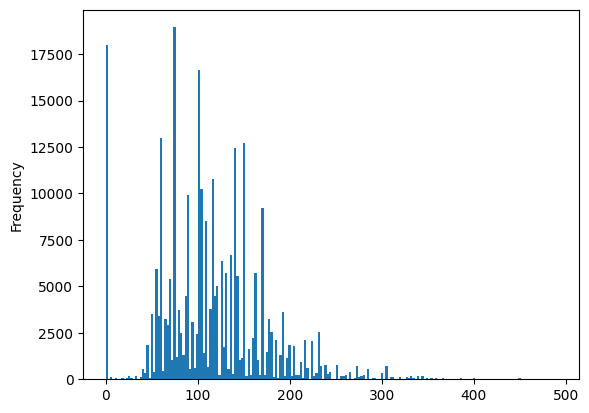

In [30]:
# Посмотрим на срез по мощности
data.query('power < 500')['power'].plot(kind = 'hist', bins = 200);

In [31]:
data['power'].quantile([.05, 0.99])

0.05      0.0
0.99    306.0
Name: power, dtype: float64

> Нулевая мощность может свидетельствовать о  том, что машина продается по частям. А слишком большая мощность - неточность. Предельно допустимая мощность будет 306, так как 99%-квантиль говорит о том, что 99% машин имеют мощность до 305 л.с. С нулевой мощностью тоже надо бороться, нижний предел установим 30, так как на [авито](https://www.avito.ru/all/avtomobili?cd=1&f=ASgCAgECAUWMFBl7ImZyb20iOjE0NzgzLCJ0byI6MTQ3ODR9&s=2) нет машин с мощностью меньше 30 л.с.

In [32]:
data = data.query(' 30 < power < 306').reset_index(drop=True)

In [33]:
# удаляем неинформативные столбцы
data = data.drop(['date_crawled', 'date_created', 'number_of_pictures','postal_code', 
                  'last_seen', 'registration_month', 'year_created','month_created'], axis=1)

In [34]:
# Посмотрим на распределения после преобразования
def df_after_transformation(data):
    data.info()
    display(data.describe())
    print('Количество пропусков в %')
    display(pd.DataFrame(round(data.isna().mean()*100)).style.background_gradient('BuPu'))
    print('Какой процент данных был удален:', (len(data_original) - len(data))/len(data_original)* 100, '%')
    
    # Так как данные распределены ненормально, то используем коэф. корреляции Спирмена
    # Фильтрация только числовых столбцов
    numeric_data = data.select_dtypes(include=[np.number])   
    display(sns.heatmap((numeric_data).corr(method='spearman'), annot = True, vmin=-1, vmax=1, center= 0)) 
    
    
    # Выделим числовые признаки в отдельную группу и проведем корреляционный анализа таких данных.
    numerical_columns = ['price', 'registration_year', 'power','kilometer']
    for s in numerical_columns:
        
        plt.figure(figsize = (20,20))
        plt.subplot(3, 3, 1)
        data[s].plot(kind = 'hist', bins = 100, title = f' Распределение признака: {s}');

    sns.pairplot(data[numerical_columns]);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263249 entries, 0 to 263248
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              263249 non-null  int64 
 1   vehicle_type       263249 non-null  object
 2   registration_year  263249 non-null  int64 
 3   gearbox            263249 non-null  object
 4   power              263249 non-null  int64 
 5   model              263249 non-null  object
 6   kilometer          263249 non-null  int64 
 7   fuel_type          263249 non-null  object
 8   brand              263249 non-null  object
 9   repaired           263249 non-null  object
dtypes: int64(4), object(6)
memory usage: 20.1+ MB


,price,registration_year,power,kilometer
count,263249.000000,263249.000000,263249.000000,263249.000000
mean,5107.262968,2002.955700,120.681097,127596.192198
std,4596.357537,6.044512,48.806351,36769.045073
min,301.000000,1961.000000,31.000000,5000.000000
25%,1500.000000,1999.000000,80.000000,125000.000000
50%,3500.000000,2003.000000,115.000000,150000.000000
75%,7360.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2015.000000,305.000000,150000.000000


Количество пропусков в %


,0
price,0.000000
vehicle_type,0.000000
registration_year,0.000000
gearbox,0.000000
power,0.000000
model,0.000000
kilometer,0.000000
fuel_type,0.000000
brand,0.000000
repaired,0.000000


Какой процент данных был удален: 25.7133101371734 %


<Axes: >

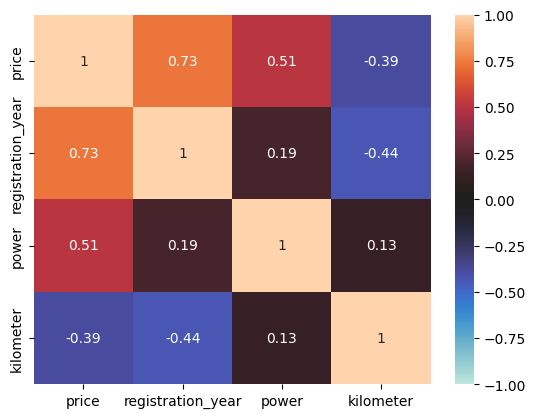

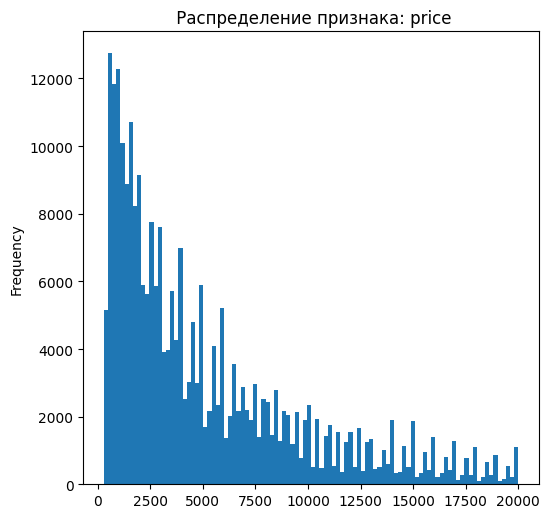

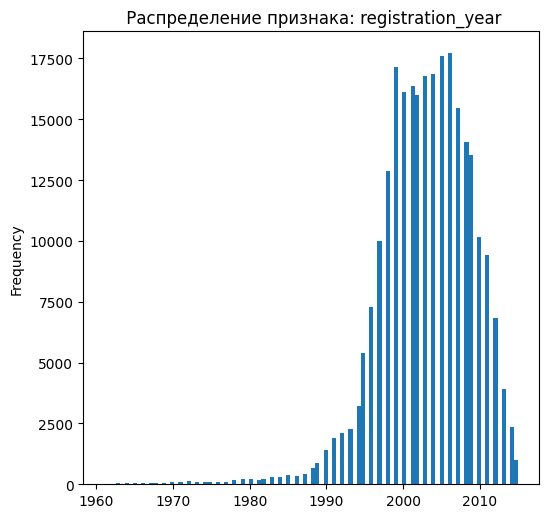

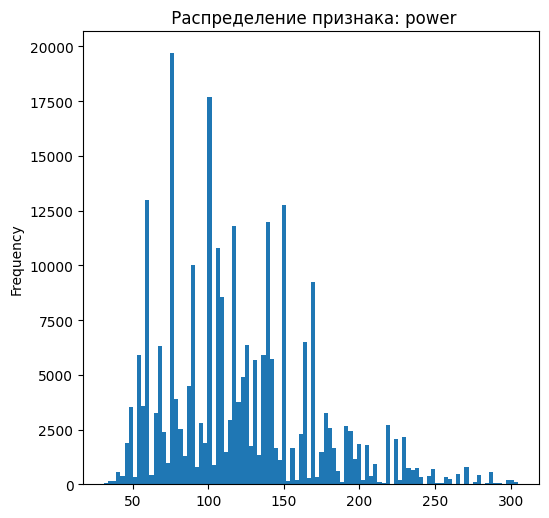

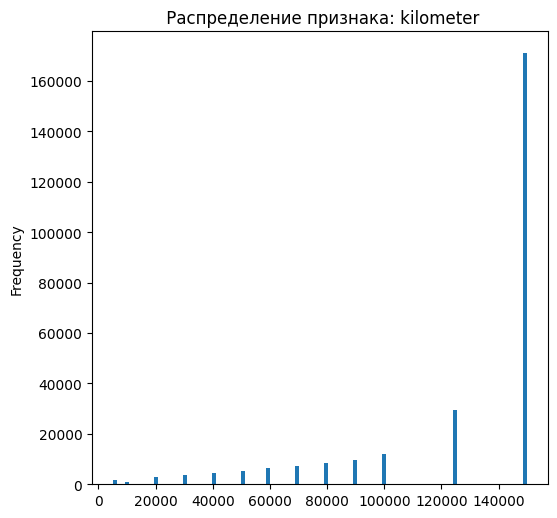

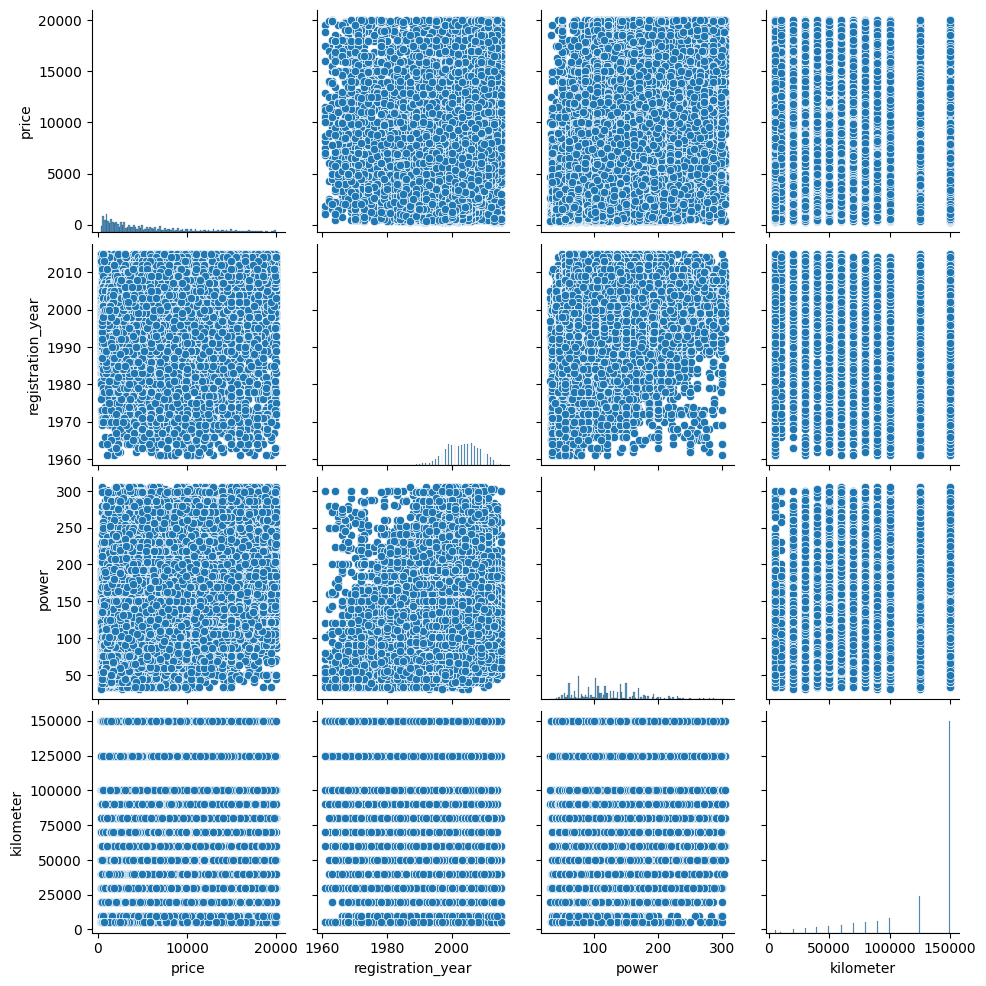

In [35]:
df_after_transformation(data)

> После предобработки данных усилилась корреляция в достоверное направление 

In [36]:
print('Pearson correlation:', spearmanr(data['registration_year'], data['price']))

Pearson correlation: SignificanceResult(statistic=0.7316778026542872, pvalue=0.0)


Так как p-value < 0.05 (типичное пороговое значение), то делаем вывод о том, что взаимосвязь (корреляция) между регистрационным номером и ценой статистически значима.

>**Промежуточный вывод по 1 этапу**
>1. Обработали пропуски в категоральных признаках: присвоили им отдельную категорию "other"
>2. Обработили аномалии в численных признаках: удалили слишком выбивающиеся значений. Удалили ~25.7% от начального датасета
>3. Удалили не информативные столбцы
>4. Корреляция Спирмена усилилась в достоверное направление после обработки данных

-----
## Обучение моделей

----

> **Перед нами задача регрессии**

In [37]:
features_train, features_test, target_train, target_test = train_test_split(
    data.drop('price', axis=1), data.price, test_size=0.4, random_state = RANDOM_STATE)

In [38]:
# Преобразуем техникой OHE категоральные признаки
cat_features = ['vehicle_type', 'gearbox', 'model', 'brand', 'fuel_type', 'repaired'] # здесь хранится список(list) столбцов, которые нужно закодировать

features_train_categories = features_train[cat_features]
features_test_categories = features_test[cat_features]

encoder = OneHotEncoder(drop='first', handle_unknown = 'infrequent_if_exist')

ohe_features_train = encoder.fit_transform(features_train_categories).toarray() # здесь получаем новые данные в виде numpy массива
ohe_features_test = encoder.transform(features_test_categories).toarray()


encoded_columns = list(encoder.get_feature_names_out()) # здесь получаем список новых столбцов

features_train_categories_new = pd.DataFrame(data= ohe_features_train, 
                                             columns= encoded_columns,
                                             index= features_train_categories.index)

features_test_categories_new = pd.DataFrame(data= ohe_features_test, 
                                            columns= encoded_columns, 
                                            index= features_test_categories.index)   


features_train_ohe = pd.concat([features_train, features_train_categories_new], axis=1)
features_test_ohe = pd.concat([features_test, features_test_categories_new], axis=1)

In [39]:
features_train_ohe = features_train_ohe.drop(['vehicle_type', 'gearbox', 'model', 'brand', 'fuel_type', 'repaired'], axis = 1)
features_test_ohe = features_test_ohe.drop(['vehicle_type', 'gearbox', 'model', 'brand', 'fuel_type', 'repaired'], axis = 1)

---
### Линейная регрессия

---

На простой линейной регрессии стандартизация не должна оказывать никакого влияния, поскольку все изменения переменной можно нивелировать за счет изменения коэффициента:

$y = \alpha + \beta X$ - без стандартизации

$y = \alpha_{st} + \beta_{st} \frac{X-mean}{std} = (\alpha_{st} - \frac{\beta_{st}mean}{std}) + (\frac{\beta_{st}}{std}) X$ - со стандартизацией

При этом $\alpha = (\alpha_{st} - \frac{\beta_{st}mean}{std})$ и $\beta = (\frac{\beta_{st}}{std})$.

In [40]:
num_features = ['registration_year', 'power', 'kilometer'] # список численных признаков, не забываем, что price - target

# Промасштабируем признаки, так как линейные модели очень чувствительные
scaler = StandardScaler()

scaler.fit(features_train_ohe[num_features])

scaler_features_train_ohe = features_train_ohe.copy()
scaler_features_test_ohe = features_test_ohe.copy()

scaler_features_train_ohe = scaler.transform(features_train_ohe[num_features])
scaler_features_test_ohe = scaler.transform(features_test_ohe[num_features])

# таргеты нельзя стандартизировать

In [41]:
%%time
# Без масштаба
model_linear = LinearRegression()
model_linear.fit(features_train_ohe, target_train)
scores_linear = (cross_val_score(model_linear, features_train_ohe, 
                                 target_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean() * -1)

print('rmse:', scores_linear)

rmse: 2495.9782579764696
CPU times: total: 1min 30s
Wall time: 1min


In [42]:
%%time
# С масштабом
model_linear_scaler = LinearRegression()
model_linear_scaler.fit(scaler_features_train_ohe, target_train)
scores_linear_scaler = (cross_val_score(model_linear_scaler, scaler_features_train_ohe, 
                                 target_train, cv = 5, scoring = 'neg_root_mean_squared_error').mean() * -1)

print('rmse:', scores_linear_scaler)

rmse: 2991.31221899504
CPU times: total: 250 ms
Wall time: 414 ms


> Масштабирование ухудшает метрику качества для модели линейной регрессии

---
### DummyRegressor

---

In [43]:
%%time
model_dummy = DummyRegressor()
model_dummy.fit(features_train, target_train)
scores_dummy = (cross_val_score(model_dummy, features_test, 
                                target_test, cv = 5, scoring = 'neg_root_mean_squared_error').mean() * -1)
print('rmse:', scores_dummy)

rmse: 4591.139386589773
CPU times: total: 219 ms
Wall time: 269 ms


----
> Будем использовать [RandomizedSearchCV](https://towardsdatascience.com/machine-learning-gridsearchcv-randomizedsearchcv-d36b89231b10)
> * [еще полезная ссылка как его использовать](https://www.projectpro.io/recipes/find-optimal-parameters-using-randomizedsearchcv-for-regression)
> * [еще](https://habr.com/ru/company/skillfactory/blog/530594/)
> * [тут можно понять что класть в scoring](https://scikit-learn.org/stable/modules/model_evaluation.html)

> В нем уже есть кросс-валидация, но работает он быстрее, чем грид

In [44]:
def randomized_search(model, parameters, features, target, model_name):
    random_cv = RandomizedSearchCV(estimator = model, cv = 5, param_distributions = parameters,
        n_jobs = -1, scoring = 'neg_root_mean_squared_error', random_state = RANDOM_STATE)
    
    random_cv.fit(features, target)
    globals()[f'rmse_{model_name}'] = random_cv.best_score_* -1
    globals()[f'time_fit_{model_name}'] = random_cv.refit_time_
    print('|best_params|:' , random_cv.best_params_) 
    print('|best RMSE|:', random_cv.best_score_ * -1) # значения RMSE на кросс-валидации при определенном гиперпараметре
    print('|best_time_fit|:' , random_cv.refit_time_) # время на fit()
    
    cv_result_best = pd.DataFrame(random_cv.cv_results_).iloc[random_cv.best_index_] # Здесь хранится таблица со всеми лучшими результатами рандомайзера
    
    print('|best_time_predict|:', cv_result_best['mean_score_time']) # время на predict()
    globals()[f'time_predict_{model_name}'] = cv_result_best['mean_score_time']

In [45]:
# Без масштаба
model_linear = LinearRegression()
parameters_linear = {}

In [46]:
%%time
# Без масштаба
randomized_search(model_linear, parameters_linear, features_train_ohe, target_train, 'model_linear')

|best_params|: {}
|best RMSE|: 2495.9782579764724
|best_time_fit|: 12.221680879592896
|best_time_predict|: 0.5222989082336426
CPU times: total: 29.3 s
Wall time: 1min 46s


In [47]:
# С масштабом
model_linear_scaler = LinearRegression()
parameters_linear_scaler = {}

In [48]:
%%time
# С масштабом
randomized_search(model_linear_scaler, parameters_linear_scaler, scaler_features_train_ohe, target_train, 'model_linear_scaler')

|best_params|: {}
|best RMSE|: 2991.31221899504
|best_time_fit|: 0.046911001205444336
|best_time_predict|: 0.0
CPU times: total: 156 ms
Wall time: 808 ms


In [49]:
model_dummy = DummyRegressor()
parameters_dummy = {}

In [50]:
%%time
randomized_search(model_dummy, parameters_dummy, features_train, target_train, 'model_dummy')

|best_params|: {}
|best RMSE|: 4599.835841819585
|best_time_fit|: 0.0
|best_time_predict|: 0.00023274421691894532
CPU times: total: 484 ms
Wall time: 934 ms


---
### Решающее дерево

---

> Для деревяных моделей лучше использовать порядковое кодирование категориальных переменных. Это может сократить время работы модели без потери качества.

In [51]:
# Ordinal Encoder для деревянных моделей и бустинга
encoder_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

oe_features_train = encoder_ordinal.fit_transform(features_train_categories) 
oe_features_test = encoder_ordinal.transform(features_test_categories)


features_train_categories_new_oe = pd.DataFrame(data= oe_features_train, 
                                             columns = ['vehicle_type_oe', 'gearbox_oe', 'model_oe',
                                                        'brand_oe', 'fuel_type_oe', 'repaired_oe'], 
                                             index= features_train_categories.index)

features_test_categories_new_oe = pd.DataFrame(data= oe_features_test, 
                                            columns= ['vehicle_type_oe', 'gearbox_oe', 'model_oe',
                                                        'brand_oe', 'fuel_type_oe', 'repaired_oe'], 
                                            index= features_test_categories.index)   


features_train_oe = pd.concat([features_train, features_train_categories_new_oe], axis=1)
features_test_oe = pd.concat([features_test, features_test_categories_new_oe], axis=1)

In [52]:
features_train_oe = features_train_oe.drop(columns= cat_features) 
features_test_oe = features_test_oe.drop(columns= cat_features) 

In [53]:
model_tree = DecisionTreeRegressor()
parameters_tree = {'max_depth': range(1,20)}

In [54]:
%%time
randomized_search(model_tree, parameters_tree, features_train_oe, target_train, 'model_tree')

|best_params|: {'max_depth': 14}
|best RMSE|: 1831.6648579339605
|best_time_fit|: 0.6512000560760498
|best_time_predict|: 0.03446969985961914
CPU times: total: 1.59 s
Wall time: 13.5 s


------
### LightGBM

---

[кодирование для lightGBM](https://www.kaggle.com/code/mlisovyi/beware-of-categorical-features-in-lgbm)

In [55]:
model_lgbm = LGBMRegressor()
parameters_lgbm = { 'n_estimators' : np.arange(1, 100, 10),
                   'max_depth': np.arange(1,10,2),
                   'learning_rate': np.arange(0.1, 1, 0.5)} # скорость обучения

In [56]:
%%time
randomized_search(model_lgbm, parameters_lgbm, features_train_oe, target_train, 'model_lgbm')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 157949, number of used features: 9
[LightGBM] [Info] Start training from score 5104.036822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|best_params|: {'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.6}
|best RMSE|: 1594.9658741598698
|best_time_fit|: 1.5319442749023438
|best_time_predict|: 0.136008358001709
CPU times: total: 2.98 s
Wall time: 26.5 s


----
### CatBoostRegressor

----

In [57]:
model_cat = CatBoostRegressor()
parameters_cat = {'iterations': np.arange(1, 100, 10),
                  'depth': np.arange(1, 10, 2),
                  'learning_rate': np.arange(0.1, 1, 0.5)}

In [58]:
%%time
randomized_search(model_cat, parameters_cat, features_train_oe, target_train, 'model_cat')

0:	learn: 3059.9413662	total: 166ms	remaining: 6.63s
1:	learn: 2500.0376640	total: 197ms	remaining: 3.85s
2:	learn: 2269.3095225	total: 222ms	remaining: 2.81s
3:	learn: 2166.1171740	total: 248ms	remaining: 2.29s
4:	learn: 2085.2933711	total: 270ms	remaining: 1.95s
5:	learn: 2030.4642316	total: 295ms	remaining: 1.72s
6:	learn: 1998.5215572	total: 318ms	remaining: 1.54s
7:	learn: 1970.4655539	total: 342ms	remaining: 1.41s
8:	learn: 1945.5868680	total: 373ms	remaining: 1.33s
9:	learn: 1923.3405087	total: 419ms	remaining: 1.3s
10:	learn: 1902.6764906	total: 470ms	remaining: 1.28s
11:	learn: 1885.1091021	total: 503ms	remaining: 1.22s
12:	learn: 1868.7272100	total: 536ms	remaining: 1.15s
13:	learn: 1857.6382712	total: 563ms	remaining: 1.08s
14:	learn: 1848.5421491	total: 593ms	remaining: 1.03s
15:	learn: 1841.8103706	total: 638ms	remaining: 997ms
16:	learn: 1835.6751861	total: 675ms	remaining: 953ms
17:	learn: 1822.9799008	total: 703ms	remaining: 898ms
18:	learn: 1813.8838768	total: 734ms	re

---
## Анализ моделей

---

In [59]:
table = {
    'Model': ['LinearRegression no scale',  
              'LinearRegression from scale', 
              'DummyRegressor', 
              'DecisionTreeRegressor',
              'LightGBM', 
              'CatBoost'],
    
    'RMSE': [rmse_model_linear, 
             rmse_model_linear_scaler, 
             rmse_model_dummy, 
             rmse_model_tree, 
             rmse_model_lgbm,
             rmse_model_cat],
    
     'время на predict в сек': [time_predict_model_linear, 
                                time_predict_model_linear_scaler, 
                                time_predict_model_dummy,
                                time_predict_model_tree, 
                                time_predict_model_lgbm, 
                                time_predict_model_cat],
    
    'время на fit в сек': [time_fit_model_linear, 
                           time_fit_model_linear_scaler, 
                           time_fit_model_dummy, 
                           time_fit_model_tree, 
                           time_fit_model_lgbm, 
                           time_fit_model_cat]}
table_scan = pd.DataFrame(data = table)
table_scan

,Model,RMSE,время на predict в сек,время на fit в сек
0,LinearRegression no scale,2495.978258,0.522299,12.221681
1,LinearRegression from scale,2991.312219,0.000000,0.046911
2,DummyRegressor,4599.835842,0.000233,0.000000
3,DecisionTreeRegressor,1831.664858,0.034470,0.651200
4,LightGBM,1594.965874,0.136008,1.531944
5,CatBoost,1716.462137,0.036611,1.787004


In [60]:
%%time
# Проверка наилучшей модели LightGBM на тестовой выборке
model_best = LGBMRegressor(n_estimators = 31, max_depth = 5, learning_rate = 0.6)
model_best.fit(features_train_oe, target_train)
best_model_predict = model_best.predict(features_test_oe)
print('rmse налучшей модели lightGBM на test`e:', (mean_squared_error(best_model_predict, target_test))**0.5)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 552
[LightGBM] [Info] Number of data points in the train set: 157949, number of used features: 9
[LightGBM] [Info] Start training from score 5104.036822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [61]:
#%%time
# Проверка наилучшей модели CatBoostRegressor на тестовой выборке
#model_best = CatBoostRegressor(learning_rate =  0.27, iterations = 907, depth = 7)
#model_best.fit(features_train, target_train)
#best_model_predict = model_best.predict(features_test)
#print('rmse налучшей модели CatBoostRegressor на test`e:',(mean_squared_error(best_model_predict, target_test))**0.5)

-----
## Вывод
----

1. Сделали предобработку данных: категоральные пропуски заменили на "other", численные аномалии удалили
2. После предобработки данных усилилась корреляция в достоверное направление
3. Преобразовали техникой OHE категоральные признаки 
4. Обучили несколько моделей:
  * Линейную регрессию
  * dummy
  * дерево
  * lightGBM
  * catboost
5. Представили интересующие критерии в виде таблицы и сделали вывод по ней
6. Масштабирование признаков для линейной регрессии ухудшает метрику
7. lightGBM и catboost можно назвать конкурентами. Но предпочтительнее использовать **lightGBM**, так как время ее обучения быстрее, a rmse почти такая же
8. Проверка на тестовой выборке показала, что **lgbm** ялвяется хорошей моделью.


        
"Tutorial: CatBoost Overview"
        
https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview/notebook
